In [1]:
import sys
import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

# add GADES to the path
GADES_path = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "GADES"))
sys.path.append(GADES_path)
from utils import muller_brown_potential_plot as get_U_plot
from utils import muller_brown_force_plot as get_F_plot
from utils import muller_brown_hessian_plot as get_H_plot
from utils import muller_brown_force_base as get_F
from utils import null_force
from utils import baoab_langevin_integrator as integrator
from utils import muller_brown_gad_force_base as get_gad_F

In [2]:
# Create a grid of x and y values
x0 = np.linspace(-3.5, 2.0, 30)
x1 = np.linspace(-1.5, 3.5, 30)
X0, X1 = np.meshgrid(x0, x1)

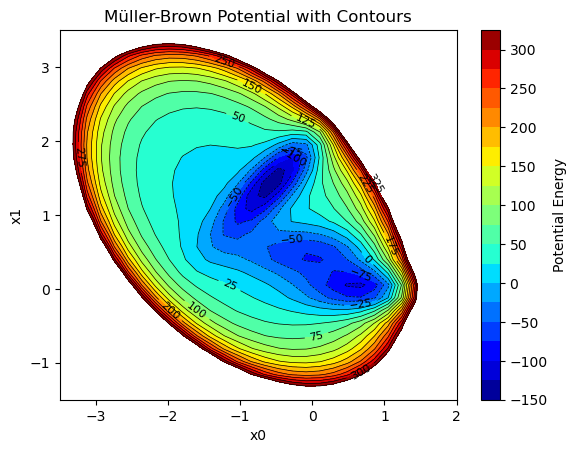

In [3]:
# plotting potential landscape

# Calculate the potential energy at each point
Z = get_U_plot(x0, x1)

# set levels for plotting
countour_levels = np.arange(-150,350,25)

# Create the filled contour plot
plt.contourf(X0, X1, Z, levels=countour_levels, cmap='jet')
plt.colorbar(label='Potential Energy')

# Add contour lines
contour_lines = plt.contour(X0, X1, Z, levels=countour_levels, colors='black', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add labels and title
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Müller-Brown Potential with Contours')

# Show the plot
plt.show()

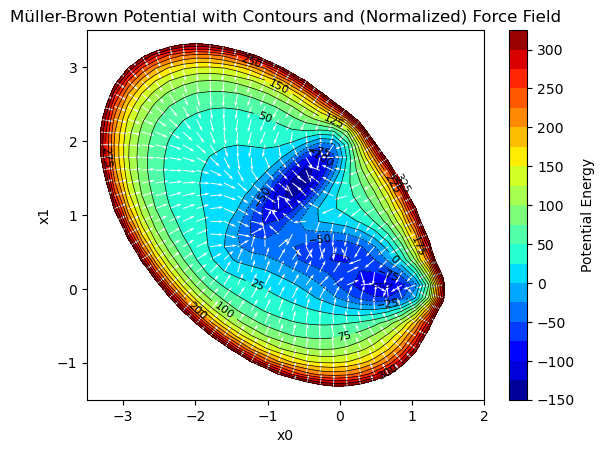

In [4]:
# plotting potential landscape with force field

# computing gradients over the grid
F = get_F_plot(x0, x1)
FX = F[:, :, 0]
FY = F[:, :, 1]

# computing normalized gradient vectors
FXn = FX.copy()
FYn = FY.copy()
norm = np.sqrt(FX**2 + FY**2)
FXn /= norm
FYn /= norm

# Create the filled contour plot
plt.contourf(X0, X1, Z, levels=countour_levels, cmap='jet')
plt.colorbar(label='Potential Energy')

# Add contour lines
contour_lines = plt.contour(X0, X1, Z, levels=countour_levels, colors='black', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add gradient vectors
plt.quiver(X0, X1, FXn, FYn, color="white", scale=30)

# Add labels and title
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Müller-Brown Potential with Contours and (Normalized) Force Field')

# Show the plot
plt.show()

In [5]:
H = get_H_plot(x0,x1)

GX = np.zeros_like(FX)
GY = np.zeros_like(FY)

n = len(x0)
for ii in range(0,n):
  for jj in range(0,n):

    # extracting Hessian at point (ii,jj)
    h = H[ii,jj,:,:]

    # solving for smallest evec by power iteration
    #w, v = power_iteration(h, mu=0., num_iters=100, tol=1e-6)

    # solving for smallest evec by eigh
    w, v = jnp.linalg.eigh(h)
    w = w[0]
    v = v[:,0]

    # extracting smallest Hessian evec into GX, GY
    GX[ii,jj] = v[0]
    GY[ii,jj] = v[1]

    # aligning gentlest ascent directions with gradient
    s = np.sign(-FX[ii,jj]*GX[ii,jj] - FY[ii,jj]*GY[ii,jj])
    GX[ii,jj] *= s
    GY[ii,jj] *= s

/var/folders/wt/mj85p2nx15lf4smkwmg0fnr80000gn/T/ipykernel_1194/1877868709.py:7: RuntimeWarning: invalid value encountered in divide
  GXn /= norm
/var/folders/wt/mj85p2nx15lf4smkwmg0fnr80000gn/T/ipykernel_1194/1877868709.py:8: RuntimeWarning: invalid value encountered in divide
  GYn /= norm


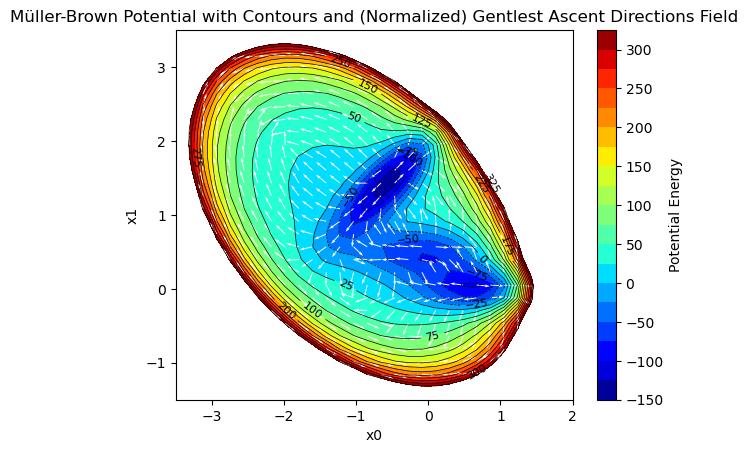

In [6]:
# plotting potential landscape with gentlest ascent field

# normalizing gentlest ascent directions
GXn = GX.copy()
GYn = GY.copy()
norm = np.sqrt(GXn**2 + GYn**2)
GXn /= norm
GYn /= norm

# Create the filled contour plot
plt.contourf(X0, X1, Z, levels=countour_levels, cmap='jet')
plt.colorbar(label='Potential Energy')

# Add contour lines
contour_lines = plt.contour(X0, X1, Z, levels=countour_levels, colors='black', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add gradient vectors
plt.quiver(X0, X1, GXn, GYn, color="white", scale=30)

# Add labels and title
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Müller-Brown Potential with Contours and (Normalized) Gentlest Ascent Directions Field')

# Show the plot
plt.show()

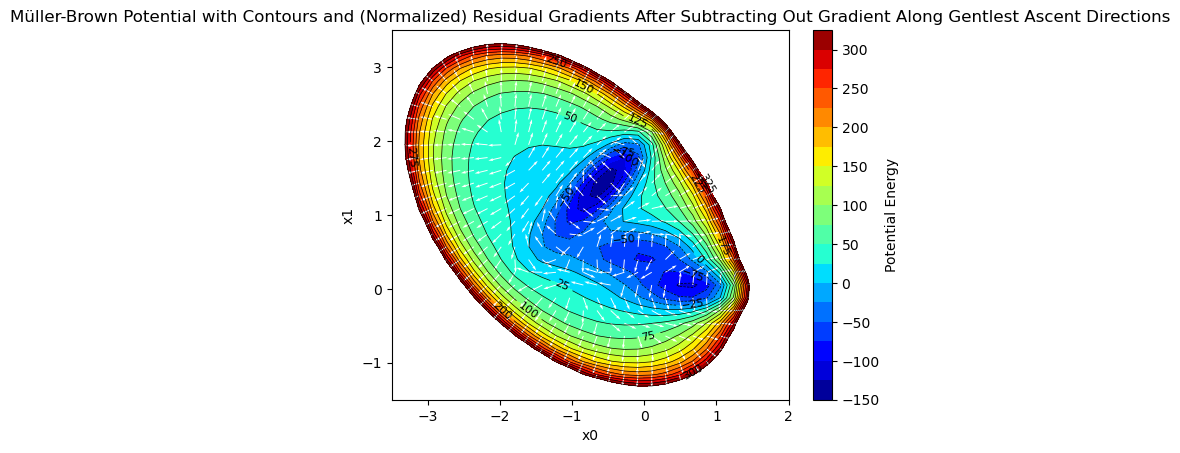

In [7]:
# plotting potential landscape with residual gradients after removing gradient in gentlest ascent directions

# Computing residual gradients after subtracting out gradient component along gentlest ascent directions
RX = np.zeros_like(FX)
RY = np.zeros_like(FY)

n = len(x0)
for ii in range(0,n):
  for jj in range(0,n):
    grad = np.array([-FX[ii,jj], -FY[ii,jj]])
    gad_n = np.array([GXn[ii,jj], GYn[ii,jj]])
    grad_r = grad - np.dot(grad,gad_n)*gad_n
    RX[ii,jj] = grad_r[0]
    RY[ii,jj] = grad_r[1]

# Normalizing residual gradients
RXn = RX.copy()
RYn = RY.copy()
norm = np.sqrt(RXn**2 + RYn**2)
RXn /= norm
RYn /= norm

# Create the filled contour plot
plt.contourf(X0, X1, Z, levels=countour_levels, cmap='jet')
plt.colorbar(label='Potential Energy')

# Add contour lines
contour_lines = plt.contour(X0, X1, Z, levels=countour_levels, colors='black', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add gradient vectors
plt.quiver(X0, X1, RXn, RYn, color="white", scale=30)

# Add labels and title
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Müller-Brown Potential with Contours and (Normalized) Residual Gradients After Subtracting Out Gradient Along Gentlest Ascent Directions')

# Show the plot
plt.show()

In [8]:
# Parameters
x = jnp.array([0.7,0])
v = jnp.zeros_like(x)
f = get_F(x)
fb = null_force(x)
mass = 1.0
gamma = 1.0
dt = 0.01
n_steps = 10000
kBT = 2.0  # Thermal energy

In [9]:
# prepare storage arrays
traj_p = np.full((n_steps+1, x.shape[0]), np.nan)
traj_v = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fu = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fb = np.full((n_steps+1, x.shape[0]), np.nan)

traj_p[0,:] = x
traj_v[0,:] = v
traj_fu[0,:] = f
traj_fb[0,:] = fb

In [10]:
# Run the integrator
for i in range(1,n_steps+1):

  x, v, f, fb = integrator(
    x, v, f, fb, mass, gamma, dt, kBT, get_F, null_force
  )

  traj_p[i,:] = x
  traj_v[i,:] = v
  traj_fu[i,:] = f
  traj_fb[i,:] = fb

# Convert trajectory to numpy array for analysis
traj_p = np.array(traj_p)
traj_v = np.array(traj_v)
traj_fu = np.array(traj_fu)
traj_fb = np.array(traj_fb)

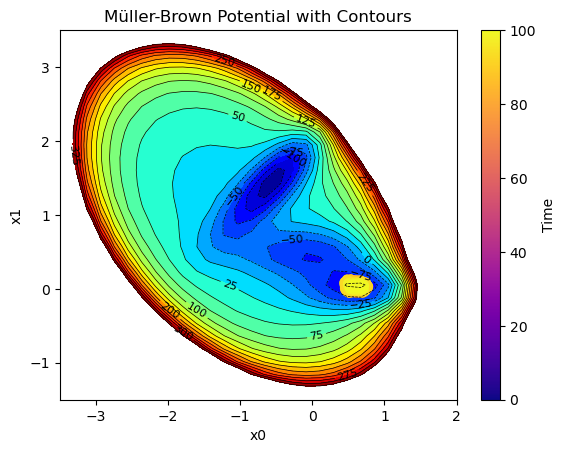

In [11]:
# Plotting trajectory over potential landscape

# set levels for plotting
countour_levels = np.arange(-150,350,25)

# Create the filled contour plot
plt.contourf(x0, x1, Z, levels=countour_levels, cmap='jet')
#plt.colorbar(label='Potential Energy')

# Add contour lines
contour_lines = plt.contour(x0, x1, Z, levels=countour_levels, colors='black', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add trajectory
x = traj_p[:,0]
y = traj_p[:,1]
time = dt * np.arange(traj_p.shape[0])
scatter = plt.scatter(x, y, c=time, cmap='plasma', marker='o', label='Trajectory')  # Color by time
plt.colorbar(scatter, label='Time')

# Add labels and title
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Müller-Brown Potential with Contours')

# Show the plot
plt.show()

In [112]:
# Parameters
x = np.array([0.7,0])
v = np.zeros_like(x)
f = get_F(x)
fb = get_gad_F(x, kappa=0.6)
mass = 1.0
gamma = 1.0
dt = 0.01
n_steps = 5000
kBT = 2.0  # Thermal energy

In [113]:
# prepare storage arrays
traj_p = np.full((n_steps+1, x.shape[0]), np.nan)
traj_v = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fu = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fb = np.full((n_steps+1, x.shape[0]), np.nan)

traj_p[0,:] = x
traj_v[0,:] = v
traj_fu[0,:] = f
traj_fb[0,:] = fb

In [114]:
# Run the integrator
for i in range(1,n_steps+1):

  x, v, f, fb = integrator(
    x, v, f, fb, mass, gamma, dt, kBT, get_F, get_gad_F
  )

  traj_p[i,:] = x
  traj_v[i,:] = v
  traj_fu[i,:] = f
  traj_fb[i,:] = fb

# Convert trajectory to numpy array for analysis
traj_p = np.array(traj_p)
traj_v = np.array(traj_v)
traj_fu = np.array(traj_fu)
traj_fb = np.array(traj_fb)

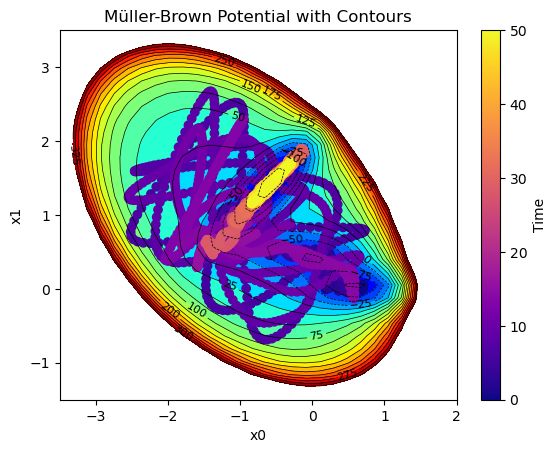

In [115]:
# Plotting trajectory over potential landscape

# set levels for plotting
countour_levels = np.arange(-150,350,25)

# Create the filled contour plot
plt.contourf(x0, x1, Z, levels=countour_levels, cmap='jet')
#plt.colorbar(label='Potential Energy')

# Add contour lines
contour_lines = plt.contour(x0, x1, Z, levels=countour_levels, colors='black', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add trajectory
x = traj_p[:,0]
y = traj_p[:,1]
time = dt * np.arange(traj_p.shape[0])
scatter = plt.scatter(x, y, c=time, cmap='plasma', marker='o', label='Trajectory')  # Color by time
plt.colorbar(scatter, label='Time')

# Add labels and title
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Müller-Brown Potential with Contours')

# Show the plot
plt.show()